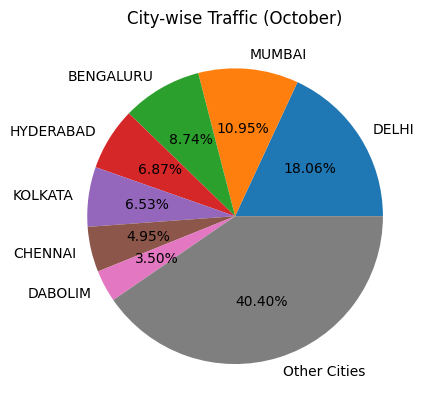

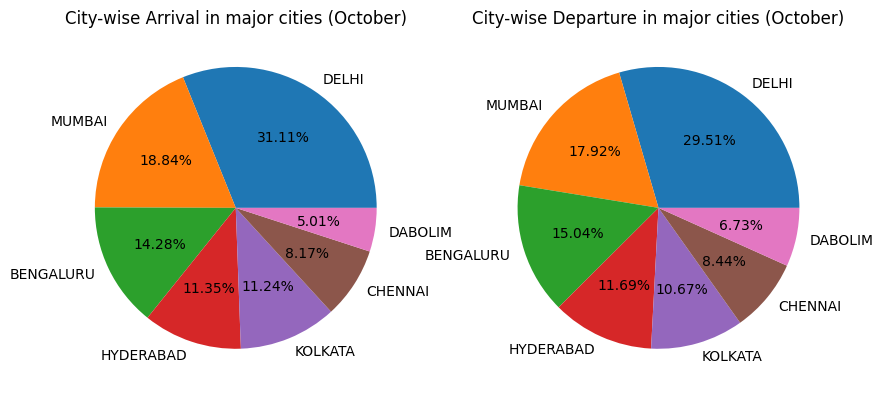

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv


def func1(file, month):
    df = pd.read_csv(file)
    # df.replace("-", float("NaN"), inplace=True)
    # df.dropna(inplace=True)
    # df['PASSENGERS TO CITY 2'] = df['PASSENGERS TO CITY 2'].replace(',', '', regex=True)
    # df['PASSENGERS TO CITY 2'] = df['PASSENGERS TO CITY 2'].astype(int)
    # df['PASSENGERS FROM CITY 2'] = df['PASSENGERS FROM CITY 2'].replace(',', '', regex=True)
    # df['PASSENGERS FROM CITY 2'] = df['PASSENGERS FROM CITY 2'].astype(int)

    # avg_passenger = 110
    # df['PASSENGERS TO CITY 2'] = (df['PASSENGERS TO CITY 2'] // avg_passenger)+1
    # df['PASSENGERS FROM CITY 2'] = (df['PASSENGERS FROM CITY 2'] // avg_passenger)+1
    # df['Total Flights'] = df['PASSENGERS TO CITY 2'] + df['PASSENGERS FROM CITY 2']
    # df = df.rename(columns={'PASSENGERS TO CITY 2': 'AVG FLIGHTS TO CITY 2','PASSENGERS FROM CITY 2': 'AVG FLIGHTS FROM CITY 2'})
    # df = df.drop(columns=['Total Flight'])

    # column_max = df['TOTAL AVG FLIGHTS'].max()
    # max_row = df[df['TOTAL AVG FLIGHTS'] == column_max]
    # print("Busiest route:")
    # print(max_row[['CITY 1','CITY 2','TOTAL AVG FLIGHTS']])

    # finding total arriving flights in a particular city
    arrival = {}
    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        count = 0
        for row in csvreader:
            #         removing 1st line
            if not count:
                count += 1
                continue
            #     for city1
            if row[1] not in arrival:
                arrival[row[1]] = int(row[4])
            else:
                arrival[row[1]] += int(row[4])
        #     for city2
            if row[2] not in arrival:
                arrival[row[2]] = int(row[3])
            else:
                arrival[row[2]] += int(row[3])
    # print(arrival)

    # finding total departuring flights from a particular city
    departure = {}
    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        count = 0
        for row in csvreader:
            #         removing 1st line
            if not count:
                count += 1
                continue
            #     for city1
            if row[1] not in departure:
                departure[row[1]] = int(row[3])
            else:
                departure[row[1]] += int(row[3])
        #     for city2
            if row[2] not in departure:
                departure[row[2]] = int(row[4])
            else:
                departure[row[2]] += int(row[4])
    # print(departure)

    cities = list(arrival.keys())
    total_traffic = np.array(list(arrival.values())) + \
        np.array(list(departure.values()))
    # print(cities)
    # print(total_traffic)

    major_cities_traffic = sorted(
        enumerate(total_traffic), key=lambda x: x[1], reverse=True)[:7]
    # print(major_cities_traffic)
    index = []
    temp = []
    for i, value in major_cities_traffic:
        index.append(i)
        temp.append(value)
    major_cities_traffic = temp
    # print(index)
    sum = 0
    for i in range(len(total_traffic)):
        if i not in index:
            sum += total_traffic[i]

    major_cities_traffic.append(sum)
    # print(major_cities_traffic)
    major_cities = [cities[i] for i in index]
    major_cities.append('Other Cities')
    # print(major_cities)

    # Citywise Traffic piechart
    plt.pie(major_cities_traffic, labels=major_cities, autopct='%1.2f%%')
    plt.title(f"City-wise Traffic ({month})")
    plt.show()

    new_major_cities = [major_cities[x] for x in range(len(major_cities)-1)]
    plt.figure(figsize=(10, 10))
    # Citywise arrival piechart
    new_arrival = [arrival[x] for x in new_major_cities]
    plt1 = plt.subplot(1, 2, 1)
    plt.pie(new_arrival, labels=new_major_cities, autopct='%1.2f%%')
    plt.title(f"City-wise Arrival in major cities ({month})")

    # Citywise departure piechart
    new_departure = [departure[x] for x in new_major_cities]
    plt2 = plt.subplot(1, 2, 2)
    plt.pie(new_departure, labels=new_major_cities, autopct='%1.2f%%')
    plt.title(f"City-wise Departure in major cities ({month})")
    plt.show()

    df.to_csv(file, index=False)
    # df.head()


func1('cleaned_file.csv', 'October')
